In [41]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import json
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)
from paths.data import SF_STANFORD_GEO_PATH, SF_SFCTA_GEO_PATH, SF_SFCTA_STANFORD_MAPPING_PATH

# Mapping SFCTA ZIPs with Stanford TAZs

This mapping is useful for scenario injection, where the user can run a scenario in downtown, midtown, or the whole city.

In [42]:
sfcta_gdf = gpd.read_file(SF_SFCTA_GEO_PATH).to_crs("EPSG:4326")

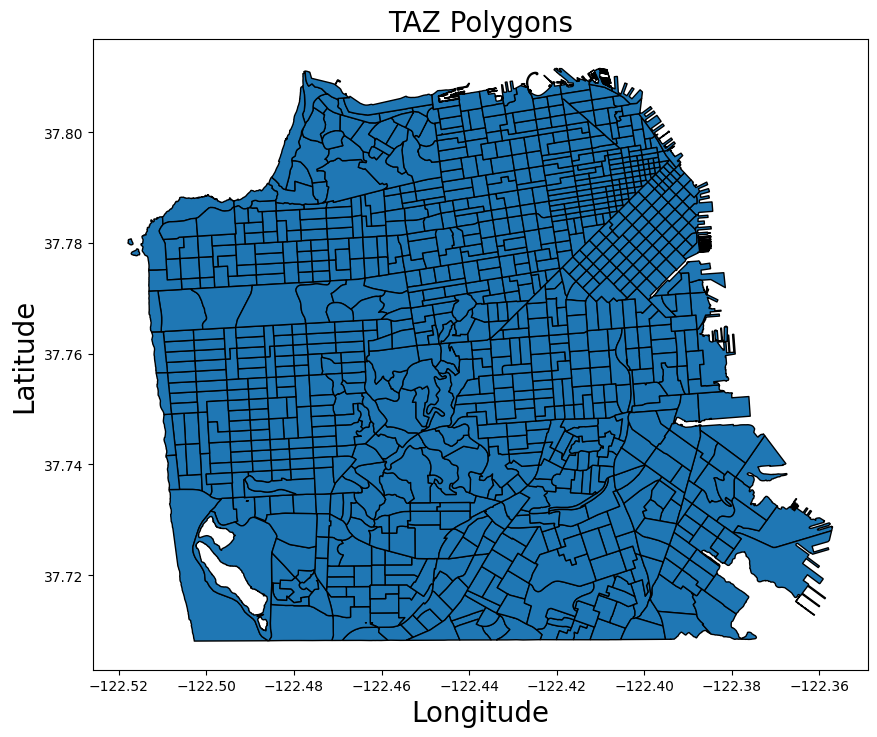

In [43]:
sfcta_gdf.plot(edgecolor="black", figsize=(10, 10))
plt.title("TAZ Polygons", fontsize=20)
plt.xlabel("Longitude", fontsize=20)
plt.ylabel("Latitude", fontsize=20)
plt.show()

In [44]:
stanford_gdf = gpd.read_file(SF_STANFORD_GEO_PATH).to_crs("EPSG:4326")

/var/folders/03/ywz8jzld3gs1b0zsd9kydy940000gq/T/ipykernel_13092/2772466310.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(stanford_gdf.geometry.centroid.x,
/var/folders/03/ywz8jzld3gs1b0zsd9kydy940000gq/T/ipykernel_13092/2772466310.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stanford_gdf.geometry.centroid.y,


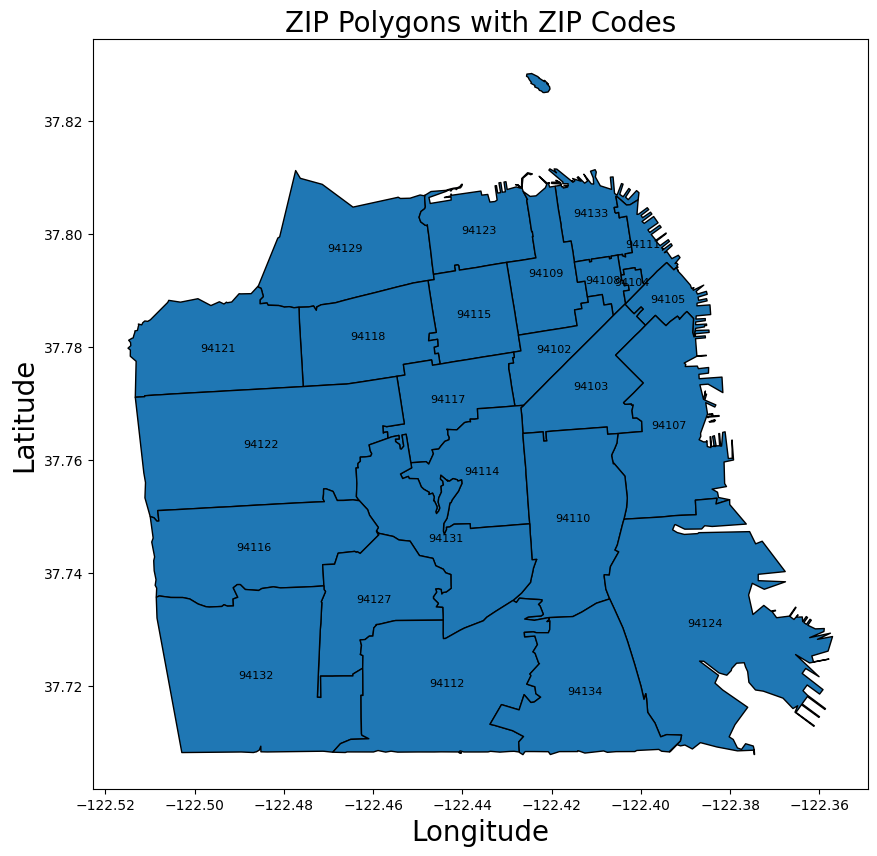

In [45]:
fig, ax = plt.subplots(figsize=(10, 10))
stanford_gdf.plot(ax=ax, edgecolor="black")
for x, y, label in zip(stanford_gdf.geometry.centroid.x,
                       stanford_gdf.geometry.centroid.y,
                       stanford_gdf["ZIP"]):
    ax.text(x, y, str(label), fontsize=8, ha='center', va='center')
ax.set_title("ZIP Polygons with ZIP Codes",  fontsize=20)
ax.set_xlabel("Longitude", fontsize=20)
ax.set_ylabel("Latitude", fontsize=20)
plt.show()

In [46]:
def map_stanford_sfcta_with_overlap(stanford_gdf, sfcta_gdf):
    # Initialize a dictionary to store mappings
    mapping = {stanford_zip: [] for stanford_zip in stanford_gdf['ZIP']}
    # Iterate over each SFCTA zone
    for _, sfcta_row in sfcta_gdf.iterrows():
        max_overlap_area = 0
        mapped_stanford_zone = None
        # For each SFCTA zone, iterate over all Stanford ZIP zones to find the one with the largest overlap
        for _, stanford_row in stanford_gdf.iterrows():
            # Check if the two geometries intersect at all
            if sfcta_row['geometry'].intersects(stanford_row['geometry']):
                # Calculate the area of the overlapping region
                overlap_area = sfcta_row['geometry'].intersection(stanford_row['geometry']).area
                # If this is the largest overlap found so far, record it
                if overlap_area > max_overlap_area:
                    max_overlap_area = overlap_area
                    mapped_stanford_zone = stanford_row['ZIP']
        # Once the Stanford ZIP with the largest overlap is found, map this SFCTA TAZ to it
        if mapped_stanford_zone is not None:
            mapping[mapped_stanford_zone].append(sfcta_row['TAZ'])
    mapping_df = pd.DataFrame([
        {'Stanford_TAZ': key, 'SFCTA_TAZ': value} for key, value in mapping.items()
    ])
    return mapping_df

In [47]:
mapping_df = map_stanford_sfcta_with_overlap(stanford_gdf, sfcta_gdf)
containment_mapping_dict = mapping_df.set_index('Stanford_TAZ').to_dict()['SFCTA_TAZ']
json_mapping = json.dumps(containment_mapping_dict, indent=4)
with open(SF_SFCTA_STANFORD_MAPPING_PATH, 'w') as file:
    file.write(json_mapping)
mapping_df

,Stanford_TAZ,SFCTA_TAZ
0,94133,"[352, 354, 357, 361, 362, 364, 371, 372, 373, ..."
1,94129,"[856, 857, 858, 859, 860, 861, 862, 863, 864, ..."
2,94123,"[356, 359, 360, 363, 365, 366, 369, 370, 377, ..."
3,94109,"[308, 318, 319, 322, 326, 327, 330, 332, 334, ..."
4,94111,"[798, 800, 801, 802, 803, 804, 805, 806, 809, ..."
5,94108,"[333, 341, 344, 346, 348, 735, 746, 747, 748, ..."
6,94115,"[275, 278, 281, 283, 290, 301, 303, 310, 311, ..."
7,94105,"[690, 723, 725, 730, 731, 732, 740, 741, 742, ..."
8,94104,"[787, 788, 789, 790, 791, 937, 938, 939, 940, ..."
9,94118,"[262, 263, 264, 266, 276, 284, 285, 287, 288, ..."


/var/folders/03/ywz8jzld3gs1b0zsd9kydy940000gq/T/ipykernel_13092/2192650718.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(stanford_gdf.geometry.centroid.x,
/var/folders/03/ywz8jzld3gs1b0zsd9kydy940000gq/T/ipykernel_13092/2192650718.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stanford_gdf.geometry.centroid.y,


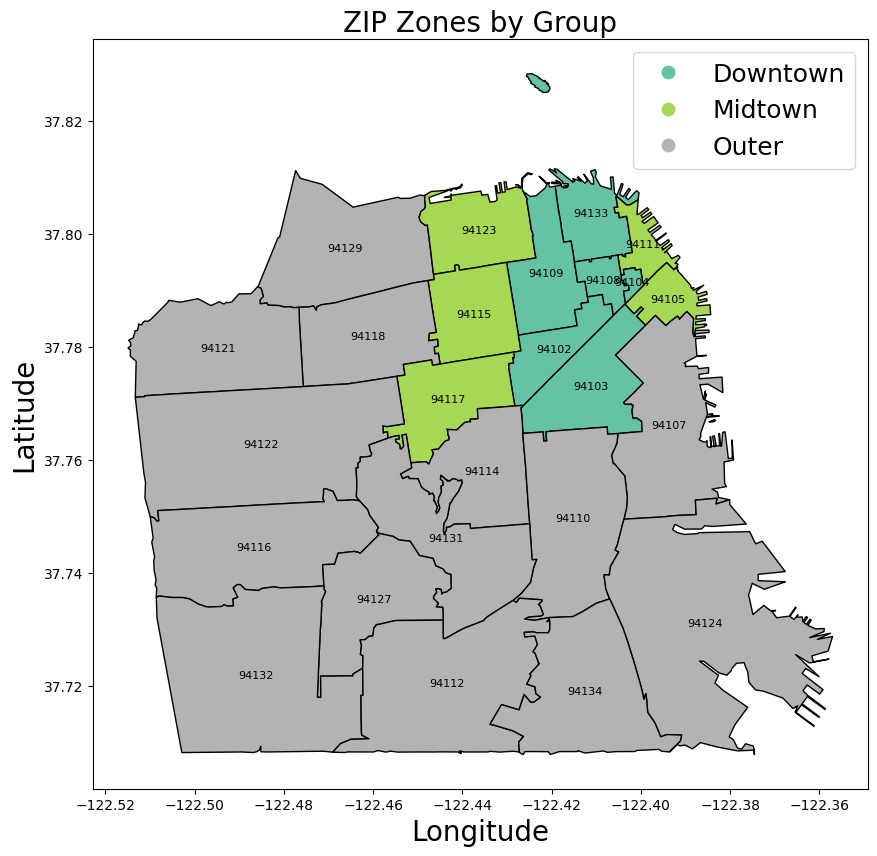

In [48]:
downtown_zips = {
    "94104", "94108", "94102", "94109", "94133", "94103"
}
midtown_zips = {
    "94104", "94108", "94102", "94109", "94133", "94103",
    "94111", "94115", "94123", "94117", "94105"
}

def assign_group(zip_code):
    if zip_code in downtown_zips:
        return "Downtown"
    elif zip_code in midtown_zips:
        return "Midtown"
    else:
        return "Outer"

stanford_gdf["group"] = stanford_gdf["ZIP"].apply(assign_group)

fig, ax = plt.subplots(figsize=(10, 10))
stanford_gdf.plot(
    column="group",
    ax=ax,
    edgecolor="black",
    cmap="Set2",
    legend=True,
    legend_kwds={"fontsize": 18}
)
for x, y, label in zip(stanford_gdf.geometry.centroid.x,
                       stanford_gdf.geometry.centroid.y,
                       stanford_gdf["ZIP"]):
    ax.text(x, y, str(label), fontsize=8, ha='center', va='center')
ax.set_title("ZIP Zones by Group", fontsize=20)
ax.set_xlabel("Longitude", fontsize=20)
ax.set_ylabel("Latitude", fontsize=20)
plt.show()